In [1]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
from torch.utils.data import DataLoader
from torchvision.transforms import Compose

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pwd

/content


In [5]:
%cd drive/MyDrive/stat430\ final\ project

/content/drive/MyDrive/stat430 final project


In [6]:
!pwd

/content/drive/MyDrive/stat430 final project


In [7]:
!ls


 cCGAN_PyTorch.ipynb   cDCGAN_PyTorch.ipynb   testdata
'cCGAN Results'       'cDCGAN Results'	      traindata


In [8]:
transform = Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
dataset_train = datasets.ImageFolder(root='traindata/', transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=64,
                                           shuffle=True)

In [9]:
dataset_test = datasets.ImageFolder(root='testdata/', transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=64,
                                           shuffle=False)

In [57]:
# training parameters
BATCH_SIZE = 64
LR = 0.0002
EPOCH = 100
img_size = 32

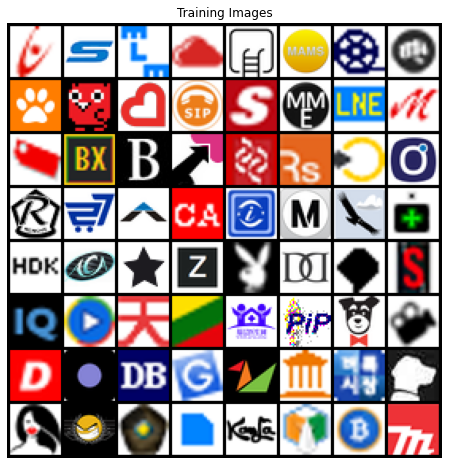

In [11]:
# Plot some training images, 
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [12]:
Z_DIM = 100
Y_DIM = NUM_CLASS = 4

In [13]:
%%capture output
# test architecture
!pip3 install pytorch_model_summary
from pytorch_model_summary import summary

In [14]:
class generator(nn.Module):
  # Paper Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
  def __init__(self):
    super(generator,self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(Z_DIM+NUM_CLASS, 256),
        nn.BatchNorm1d(256)
    )
    self.linear2 = nn.Sequential(
        nn.Linear(NUM_CLASS, 256),
        nn.BatchNorm1d(256)
    )
    self.linear3 = nn.Sequential(
        nn.Linear(512,512),
        nn.BatchNorm1d(512)
    )
    self.linear4 = nn.Sequential(
        nn.Linear(512,1024),
        nn.BatchNorm1d(1024)
    )

    self.fc = nn.Linear(1024, 3072)  #3*32*32

  def forward(self, x, label):
    x = torch.cat([x,label],1)#[64,104]

    x = F.relu(self.linear1(x)) # [64,256]
    y = F.relu(self.linear2(label)) #[64,256]

    x = torch.cat([x, y], 1)#[64,512]

    x = F.relu(self.linear3(x))#[64,512]
    x = F.relu(self.linear4(x)) #[64,1024]
    x = torch.tanh(self.fc(x))
    return x

In [15]:
g = generator()
print(summary(g, torch.zeros(64,100),torch.zeros(64,NUM_CLASS)))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1           [64, 256]          26,880          26,880
     BatchNorm1d-2           [64, 256]             512             512
          Linear-3           [64, 256]           1,280           1,280
     BatchNorm1d-4           [64, 256]             512             512
          Linear-5           [64, 512]         262,656         262,656
     BatchNorm1d-6           [64, 512]           1,024           1,024
          Linear-7          [64, 1024]         525,312         525,312
     BatchNorm1d-8          [64, 1024]           2,048           2,048
          Linear-9          [64, 3072]       3,148,800       3,148,800
Total params: 3,969,024
Trainable params: 3,969,024
Non-trainable params: 0
-----------------------------------------------------------------------


In [39]:
class discriminator(nn.Module):
  # initializers
  def __init__(self):
    super(discriminator, self).__init__()
    self.fc1 = nn.Linear(3072, 1024)
    self.fc2 = nn.Linear(NUM_CLASS, 1024)

    self.linear1 = nn.Sequential(
        nn.Linear(2048,512),
        nn.BatchNorm1d(512)
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512,256),
        nn.BatchNorm1d(256)
    )

    self.fc = nn.Linear(256, 1)

  # forward method
  def forward(self, x, label):
    #x:[64,3072],label:[64,num_class]
    # x = torch.reshape(x,(-1,3*32*32))
    x = F.leaky_relu(self.fc1(x), 0.2)# [64,1024].  6144x32 and 3072x1024)

    y = F.leaky_relu(self.fc2(label), 0.2)#[64,1024]

    x = torch.cat([x, y], 1)#[64,2048]

    x = F.leaky_relu(self.linear1(x), 0.2)#[64,512]
    x = F.leaky_relu(self.linear2(x), 0.2)#[64,256]
    x = torch.sigmoid(self.fc(x))#[64,1]
    return x

In [40]:
d = discriminator()
print(summary(d, torch.zeros(64, 3072),torch.zeros(64,NUM_CLASS)))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1          [64, 1024]       3,146,752       3,146,752
          Linear-2          [64, 1024]           5,120           5,120
          Linear-3           [64, 512]       1,049,088       1,049,088
     BatchNorm1d-4           [64, 512]           1,024           1,024
          Linear-5           [64, 256]         131,328         131,328
     BatchNorm1d-6           [64, 256]             512             512
          Linear-7             [64, 1]             257             257
Total params: 4,334,081
Trainable params: 4,334,081
Non-trainable params: 0
-----------------------------------------------------------------------


In [41]:
# label helper
MAP = torch.diag(torch.ones(NUM_CLASS))
MAP

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [19]:
def label_preprocess(label):
  # change the label from dataloader in (batch_size,) to (batch_size,num_class)
  label = label.type(torch.LongTensor)
  return MAP[label]

In [20]:
# test for function label_preprocess(label)
tst = torch.zeros(2)
label_preprocess(tst)

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.]])

In [21]:
# for the purpose of designing logos using the same random numbers each time during training
NUM_TEST = NUM_CLASS*NUM_CLASS
fixed_z = torch.randn(NUM_TEST,100).to(device)
test_label = torch.randint(NUM_CLASS, (NUM_TEST,))
fixed_y = label_preprocess(test_label).to(device)
print("random inputs for test: ",fixed_z.shape)
print("random class for test: ",fixed_y.shape)

random inputs for test:  torch.Size([16, 100])
random class for test:  torch.Size([16, 4])


In [69]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):

    G.eval()
    test_images = G(fixed_z, fixed_y)
    G.train()

    size_figure_grid = 4
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        out = (test_images[k].cpu().data.view(32, 32,3).numpy() * 255).astype(np.uint8)
        ax[i, j].imshow(out)#, cmap='gray'

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [70]:
show_result(100, show = False, save = True, path = 'result.png')

In [43]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [44]:
from torch.optim.lr_scheduler import StepLR


In [45]:
# network
G = generator()
D = discriminator()
G.to(device)
D.to(device)

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=LR, betas=(0.9, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=LR, betas=(0.9, 0.999))
G_scheduler = StepLR(G_optimizer, step_size = 2, gamma = 0.1)
D_scheduler = StepLR(D_optimizer, step_size = 2, gamma = 0.1)

In [46]:
# results save folder
root = 'cCGAN Results/'
model = 'cCGAN_'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):# save generated result by generator
    os.mkdir(root + 'Fixed_results')

In [47]:
%%capture output
!pip3 install torchmetrics
from torchmetrics.classification import BinaryPrecision,BinaryRecall

In [50]:
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []
img_size = 32
metric_p = BinaryPrecision().to(device)
metric_r = BinaryRecall().to(device)

In [58]:
print('training start!')
start_time = time.time()
for epoch in range(EPOCH):
    D_losses = []
    G_losses = []
    real_acc = []
    fake_acc = []
    real_precisions = []
    fake_precisions = []
    real_recalls = []
    fake_recalls =[]

    # # learning rate decay
    # if (epoch+1) == 11:
    #     G_optimizer.param_groups[0]['lr'] /= 10
    #     D_optimizer.param_groups[0]['lr'] /= 10
    #     print("learning rate change!")

    # if (epoch+1) == 16:
    #     G_optimizer.param_groups[0]['lr'] /= 10
    #     D_optimizer.param_groups[0]['lr'] /= 10
    #     print("learning rate change!")

    epoch_start_time = time.time()
    y_real = torch.ones(BATCH_SIZE).to(device)
    y_fake = torch.zeros(BATCH_SIZE).to(device)

    for img, label in train_loader:
        # for sake of total sample size is not divisible by batch_size
        mini_batch = img.size()[0]
        if mini_batch != BATCH_SIZE:
            y_real = torch.ones(mini_batch).to(device)
            y_fake = torch.zeros(mini_batch).to(device)
        img,label_onehot = img.reshape(-1,3*32*32).to(device),label_preprocess(label).to(device) # real and fake use the same label now

        # generate random noise
        z = torch.randn(img.size(0),100).to(device)

        # generate fake image by generator
        # print("label: ",label_onehot.shape)
        fake_img = G(z,label_onehot).to(device)
        # print("data preprocessing done!")
        #-------------------data preprocessing done above-----------------------

        # # train discriminator
        D.zero_grad()
        # print("img shape: ",img.shape)
        D_result = D(img, label_onehot).squeeze()
        D_real_acc = (D_result>0.5).float().mean().item() #add
        real_acc.append(D_real_acc)
        real_precision = metric_p(D_result, y_real).item()
        real_precisions.append(real_precision)
        real_recall = metric_r(D_result, y_real).item()
        real_recalls.append(real_recall)
        

        D_real_loss = BCE_loss(D_result, y_real)

        G_result = G(z, label_onehot)
        D_result = D(G_result, label_onehot).squeeze()
        D_fake_acc = (D_result<=0.5).float().mean().item()#add
        fake_acc.append(D_fake_acc)
        fake_precision = metric_p(D_result, y_fake).item()
        fake_precisions.append(fake_precision)
        fake_recall = metric_r(D_result, y_fake).item()
        fake_recalls.append(fake_recall)

        

        D_fake_loss = BCE_loss(D_result, y_fake)
     
        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()

        D_losses.append(D_train_loss.item())
        # print("discriminator training done!")

        # train generator G
        G.zero_grad()

        G_result = G(z, label_onehot)
        D_result = D(G_result, label_onehot).squeeze()

        G_train_loss = BCE_loss(D_result, y_real)

        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.item())
        # print("generator training done!")
        # print(D_losses)




        # # train discriminator
        # D.zero_grad()

        # D_real_output = D(img, label_onehot).squeeze() # squeeze to change from (batch_size,1) to (batch_size,)
        # D_real_loss = BCE_loss(D_real_output, y_real)
        # D_fake_output = D(fake_img,label_onehot).squeeze()
        # D_fake_loss = BCE_loss(D_fake_output, y_fake)
        # D_total_loss = D_real_loss+D_fake_loss
        # D_losses.append(D_total_loss.item())

        # # D_optimizer.zero_grad()# why don't need this?
        # D_total_loss.backward()
        # D_optimizer.step()

        # # calculate the accuracy of discriminator on real/fake data
        # D_real_acc = (D_real_output>0.5).float().mean().item()# if want boolean to int, use .long()
        # D_fake_acc = (D_fake_output<=0.5).float().mean().item()

        # #---------------discriminator training done above-----------------------

        # # train generator G
        # G.zero_grad()
        # G_total_loss = BCE_loss(D_fake_output, y_real)# notice: y_real but not y_fake!
        # G_losses.append(G_total_loss.item())

        # # G_optimizer.zero_grad()# why don't need this?
        # G_total_loss.backward()
        # G_optimizer.step()
    D_scheduler.step()
    G_scheduler.step()
    
    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), EPOCH, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    # show_result((epoch+1), save=True, path=fixed_p)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

training start!
[1/100] - ptime: 3.11, loss_d: 0.904, loss_g: 1.028
[2/100] - ptime: 3.06, loss_d: 0.897, loss_g: 1.028
[3/100] - ptime: 3.06, loss_d: 0.901, loss_g: 1.031
[4/100] - ptime: 3.09, loss_d: 0.899, loss_g: 1.029
[5/100] - ptime: 3.07, loss_d: 0.901, loss_g: 1.030
[6/100] - ptime: 3.06, loss_d: 0.909, loss_g: 1.024
[7/100] - ptime: 3.04, loss_d: 0.901, loss_g: 1.028
[8/100] - ptime: 3.05, loss_d: 0.894, loss_g: 1.032
[9/100] - ptime: 3.09, loss_d: 0.903, loss_g: 1.026
[10/100] - ptime: 3.04, loss_d: 0.897, loss_g: 1.033
[11/100] - ptime: 3.09, loss_d: 0.902, loss_g: 1.024
[12/100] - ptime: 3.07, loss_d: 0.903, loss_g: 1.029
[13/100] - ptime: 3.02, loss_d: 0.903, loss_g: 1.029
[14/100] - ptime: 3.03, loss_d: 0.895, loss_g: 1.030
[15/100] - ptime: 3.07, loss_d: 0.896, loss_g: 1.032
[16/100] - ptime: 3.07, loss_d: 0.897, loss_g: 1.028
[17/100] - ptime: 3.08, loss_d: 0.896, loss_g: 1.030
[18/100] - ptime: 3.19, loss_d: 0.898, loss_g: 1.030
[19/100] - ptime: 3.16, loss_d: 0.896, 

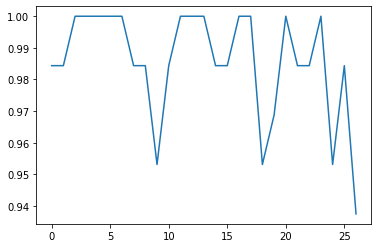

In [59]:
plt.plot(real_acc)

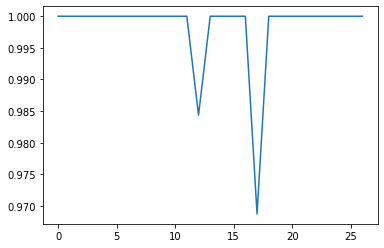

In [60]:
plt.plot(fake_acc)

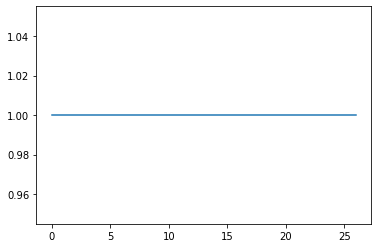

In [61]:
plt.plot(real_precisions)

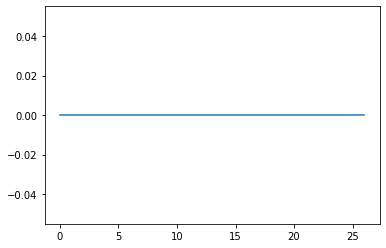

In [62]:
plt.plot(fake_precisions)

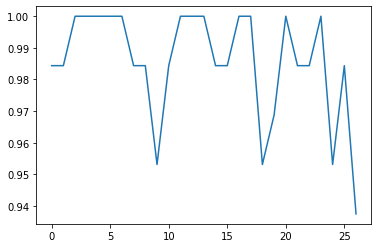

In [63]:
plt.plot(real_recalls)

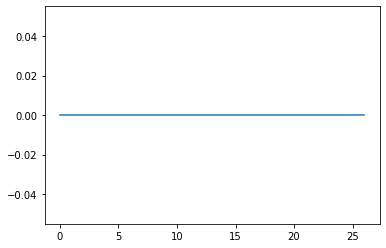

In [64]:
plt.plot(fake_recalls)

In [71]:
end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), EPOCH, total_ptime))
print("Training finish!... save training results")
torch.save(G.state_dict(), root + model + 'generator_param.pkl')
torch.save(D.state_dict(), root + model + 'discriminator_param.pkl')
with open(root + model + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path=root + model + 'train_hist.png')

images = []
for e in range(20):
    img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)